# Model - Convolutional Neural Network

In the case of the CNN classifier, we applied word-embedding procedures
from the pre-processed texts using the word2vec API of Python Package, Gensim. The word vectors were pretrained
with the training dataset collected for the current study with continuous bag-of-words representation
(CBOW) models, while the size of window was set to five. Note that by using the pre-trained word2vec model
for representing each post for each subreddit, a language style used by users who write posts in a subreddit can
be trained for the specific subreddit.

##### Import libraries

In [114]:
import pandas as pd

import numpy as np
from numpy import array
from numpy import zeros

import matplotlib.pyplot as plt

import re
import multiprocessing

# Train, test, split
from sklearn.model_selection import train_test_split

# For handling imbalanced classes
from collections import Counter
from imblearn.over_sampling import SMOTE

# Word2Vec
import gensim 
import gensim.models
from gensim.models import Word2Vec

import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

##### Load data

In [5]:
posts = pd.read_csv('../data/posts-preprocessed.csv')

In [75]:
posts.head()

,author,timeframe,text,datetime,words,word_stems,subreddit_AnorexiaNervosa,subreddit_Anxiety,subreddit_BPD,subreddit_autism,subreddit_bipolar,subreddit_bulimia,subreddit_depression,subreddit_schizophrenia
0,sub21036,pre-covid,['how can i stop hating myself i have been on...,2017-12-02 16:36:16,"['[', ""'how"", 'stop', 'hating', 'eating', 'dis...","['[', ""'how"", 'stop', 'hating', 'eating', 'dis...",0,0,0,0,0,1,0,0
1,sub12048,pre-covid,['new guy here 1 month on it 16m hi guys just...,2017-12-05 19:45:25,"['[', ""'new"", 'guy', '1', 'month', '16m', 'hi'...","['[', ""'new"", 'guy', '1', 'month', '16m', 'hi'...",0,0,0,0,0,1,0,0
2,sub6523,pre-covid,['so i just vomited blood what can i eat while...,2017-12-06 16:58:16,"['[', ""'so"", 'vomited', 'blood', 'eat', 'throa...","['[', ""'so"", 'vomited', 'blood', 'eat', 'throa...",0,0,0,0,0,1,0,0
3,sub37858,pre-covid,['recovery is expensive during recovery hi i...,2017-12-07 14:07:27,"['[', ""'recovery"", 'expensive', 'recovery', 'h...","['[', ""'recovery"", 'expensive', 'recovery', 'h...",0,0,0,0,0,1,0,0
4,sub21036,pre-covid,['extreme tongue pain i purged a few nights a...,2017-12-08 20:16:50,"['[', ""'extreme"", 'tongue', 'pain', 'purged', ...","['[', ""'extreme"", 'tongue', 'pain', 'purged', ...",0,0,0,0,0,1,0,0


##### Binarize targets using get_dummies

Will use each subreddit as target (except mental health)

In [72]:
posts = pd.get_dummies(posts, columns=['subreddit'])

In [73]:
posts.drop(columns='subreddit_mentalhealth', inplace = True)

##  Create Word2Vec model

Using **Continuous Bag of Words (CBOW) model**: CBOW model predicts the current word given context words within specific window. The input layer contains the context words and the output layer contains the current word. The hidden layer contains the number of dimensions in which we want to represent current word present at the output layer.

https://www.geeksforgeeks.org/python-word-embedding-using-word2vec/

In [7]:
# How many cores am I working with?
cores = multiprocessing.cpu_count() # Count the number of cores in this computer
cores

8

Parameters: 
- size: (default 100) The number of dimensions of the embedding, e.g. the length of the dense vector to represent each token (word).
- window: (default 5) The maximum distance between a target word and words around the target word.
- min_count: (default 5) The minimum count of words to consider when training the model; words with an occurrence less than this count will be ignored.
- workers: (default 3) The number of threads to use while training.
- sg: (default 0 or CBOW) The training algorithm, either CBOW (0) or skip gram (1).

In [18]:
w2v_model = Word2Vec(posts['words'], workers=cores-1, min_count=2)

In [21]:
vocabulary = w2v_model.wv.vocab


The word2vec algorithm processes documents sentence by sentence. This means we will preserve the sentence-based structure during cleaning.

In [32]:
## Try with 

from gensim.test.utils import datapath
from gensim import utils

class MyCorpus:
    """An iterator that yields sentences (lists of str)."""

    def __iter__(self):
        for line in posts['text']:
            # assume there's one document per line, tokens separated by whitespace
            yield utils.simple_preprocess(line)

In [33]:
sentences = MyCorpus()

In [34]:
model = gensim.models.Word2Vec(sentences=sentences, workers=cores-1)

After the model is fit, we print the size of the learned vocabulary

In [35]:
# summarize vocabulary size in model
words = list(model.wv.vocab)
print('Vocabulary size: %d' % len(words))

Vocabulary size: 70590


Finally, we save the learned embedding vectors to file using the save_word2vec_format() on the model’s ‘wv‘ (word vector) attribute. The embedding is saved in ASCII format with one word and vector per line.

In [36]:
# save model in ASCII (word2vec) format
filename = 'embedding_word2vec.txt'
model.wv.save_word2vec_format(filename, binary=False)

Load the word embedding as a directory of words to vectors. The word embedding was saved in so-called ‘word2vec‘ format that contains a header line. We will skip this header line when loading the embedding.

The function below named load_embedding() loads the embedding and returns a directory of words mapped to the vectors in NumPy format.

In [50]:
# load embedding as a dict
def load_embedding(filename):
    # load embedding into memory, skip first line
    file = open(filename,'r')
    lines = file.readlines()[1:]
    file.close()
    # create a map of words to vectors
    embedding = dict()
    for line in lines:
        parts = line.split()
    # key is string word, value is numpy array for vector
    embedding[parts[0]] = np.asarray(parts[1:], dtype='float32')
    return embedding

In [51]:
def get_weight_matrix(embedding, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = zeros((vocab_size, 100))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = embedding.get(word)
    return weight_matrix

Now we can use these functions to create our new Embedding layer for our model.

In [60]:
# create the tokenizer
tokenizer = Tokenizer()
# fit the tokenizer on the documents
tokenizer.fit_on_texts(posts['words'])

In [64]:
# define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index) + 1

In [67]:
# sequence encode
encoded_docs = tokenizer.texts_to_sequences(posts['words'])

### Train test split

In [97]:
# sequence encode
encoded_docs = tokenizer.texts_to_sequences(posts['words'])

# pad sequences
max_length = max([len(s.split()) for s in posts['words']])
X = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

# define training labels
y = posts['subreddit_AnorexiaNervosa']

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = .2,
                                                    random_state=42)

In [99]:
smote = SMOTE(random_state=42) 
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [100]:
counter = Counter(y_train_sm)
print(counter)

Counter({0: 41620, 1: 41620})


In [101]:
# load embedding from file
raw_embedding = load_embedding('embedding_word2vec.txt')
# get vectors in the right order
embedding_vectors = get_weight_matrix(raw_embedding, tokenizer.word_index)
# create the embedding layer
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_vectors], 
                            input_length=max_length, trainable=False)

In [104]:
# define model
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.25)) # dropout level specified in paper 
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 3927, 100)         8808300   
_________________________________________________________________
dropout_1 (Dropout)          (None, 3927, 100)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3923, 128)         64128     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1961, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 251008)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 251009    
Total params: 9,123,437
Trainable params: 315,137
Non-trainable params: 8,808,300
______________________________________

In [108]:
# compile network
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', 
              optimizer=opt,
              metrics=['accuracy'])

In [109]:
# Fit model on training data.
history = model.fit(X_train_sm,
                    y_train_sm, 
                    batch_size=64,
                    validation_data=(X_test, y_test),
                    epochs=50,
                    verbose=1)

Epoch 1/50
1301/1301 [==============================] - 831s 638ms/step - loss: nan - accuracy: 0.4984 - val_loss: nan - val_accuracy: 0.8866
Epoch 2/50
1301/1301 [==============================] - 729s 560ms/step - loss: nan - accuracy: 0.5022 - val_loss: nan - val_accuracy: 0.8866
Epoch 3/50
1301/1301 [==============================] - 713s 548ms/step - loss: nan - accuracy: 0.4971 - val_loss: nan - val_accuracy: 0.8866
Epoch 4/50
1301/1301 [==============================] - 711s 547ms/step - loss: nan - accuracy: 0.5023 - val_loss: nan - val_accuracy: 0.8866
Epoch 5/50
1301/1301 [==============================] - 710s 546ms/step - loss: nan - accuracy: 0.4994 - val_loss: nan - val_accuracy: 0.8866
Epoch 6/50
1301/1301 [==============================] - 711s 546ms/step - loss: nan - accuracy: 0.5013 - val_loss: nan - val_accuracy: 0.8866
Epoch 7/50
1301/1301 [==============================] - 709s 545ms/step - loss: nan - accuracy: 0.4998 - val_loss: nan - val_accuracy: 0.8866
Epoch 

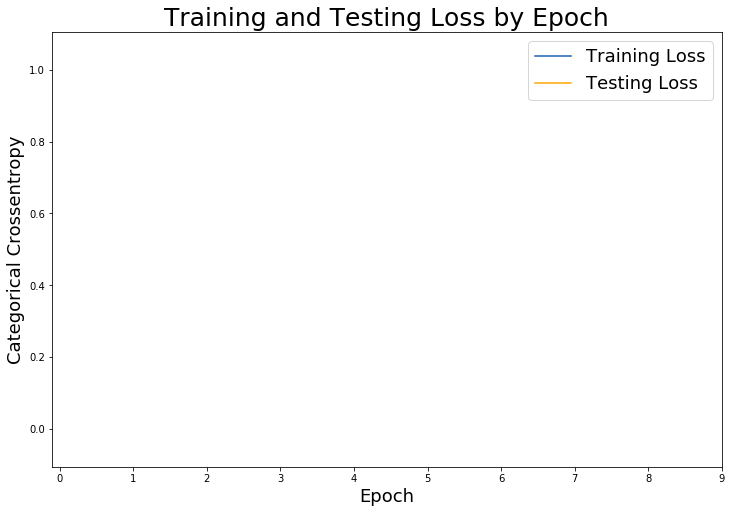

In [115]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(np.arange(10), np.arange(10))

plt.legend(fontsize = 18);